## Amazon Review Data : Data Exploration

### Setup spark

In [1]:
import os, pickle, glob, math
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.functions import col

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
from plotly.offline import iplot

py.init_notebook_mode(connected = True)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("tab10")

Matplotlib created a temporary cache directory at /tmp/matplotlib-lz0c0lsf because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "64g") \
	.config("spark.executor.memory", "64g") \
    .config('spark.executor.instances', 16) \
	.appName("Amazon Reviews") \
	.getOrCreate()

In [3]:
sqlContext = SQLContext(sc)

/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



## Read Data

### Get files

In [4]:
#######################################################################################
###################### change path to: "../clin6/amazon_data" #########################
#######################################################################################
path = "amazon_data"

In [5]:
def read(path):
    """
    Method that loads data file as df
    Takes in 1 parameter: path
    """
    return sc.read.csv(path, sep = "\t", header = True, inferSchema = True)

def get_path(file):
    """
    Method to create path
    Takes in 1 parameter: file name
    """
    return "amazon_data/%s" % file

In [6]:
dir = os.listdir(path)
files = [f for f in dir if os.path.isfile(os.path.join(path, f))]

In [7]:
def get_df(files):
    """
    Method that combines files into 1 big df
    Takes in 1 parameter: list of file names
    """
    df = read(get_path(files[0]))
    n = len(files)
    for i in range(1, n):
        data = read(get_path(files[i]))
        df = df.union(data)
    return df

### Get df and Removing Repetitive/Unnecessary Information

In [8]:
df = get_df(files)#.drop('marketplace', 'vine')
sqlContext.registerDataFrameAsTable(df, "df")

# Data Exploration Start
* Perform the data exploration step (i.e. evaluate your data, # of observations, details about your data distributions, scales, missing data, column descriptions) Note: For image data you can still describe your data by the number of classes, # of images, plot example classes of the image, size of images, are sizes uniform? Do they need to be cropped? normalized? etc.

In [9]:
### Show how our data looks like
df.show(5)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   36075342| RAB23OVFNCXZQ|B00LPRXQ4Y|     339193102|17" 2003-2006 For...|      Automotive|          1|            0|          0|   N|                Y|     As it was used,|As it was used, t...| 2015-08-31|
|         US|   42462164|R3NORADVJO6IE6|B000C7S0TO|     907684644|Spectra Premium C...|      Automotive|          5|    

In [10]:
### Total number of observations
print('There is a total of %d observations' % df.count())

There is a total of 109830520 observations


In [11]:
### Get columns
columns = df.columns
print('Columns:')
print(df.columns)

Columns:
['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']


In [12]:
### Get number of columns
num_cols = len(columns)
print('There is a total of %d columns' % num_cols)

There is a total of 15 columns


In [13]:
### Get number of missing values for each column
for i in range(num_cols):
    missing = df.filter(df[columns[i]].isNull()).count()
    print("'%s' column has %d missing values" % (columns[i], missing))

'marketplace' column has 0 missing values
'customer_id' column has 0 missing values
'review_id' column has 0 missing values
'product_id' column has 0 missing values
'product_parent' column has 0 missing values
'product_title' column has 0 missing values
'product_category' column has 1753 missing values
'star_rating' column has 1787 missing values
'helpful_votes' column has 1794 missing values
'total_votes' column has 1794 missing values
'vine' column has 1794 missing values
'verified_purchase' column has 1794 missing values
'review_headline' column has 2044 missing values
'review_body' column has 12438 missing values
'review_date' column has 8243 missing values


In [14]:
data_types = df.dtypes
for i in range(num_cols):
    print("'%s' column is of type '%s'" % (data_types[i][0], data_types[i][1]))

'marketplace' column is of type 'string'
'customer_id' column is of type 'int'
'review_id' column is of type 'string'
'product_id' column is of type 'string'
'product_parent' column is of type 'int'
'product_title' column is of type 'string'
'product_category' column is of type 'string'
'star_rating' column is of type 'string'
'helpful_votes' column is of type 'int'
'total_votes' column is of type 'int'
'vine' column is of type 'string'
'verified_purchase' column is of type 'string'
'review_headline' column is of type 'string'
'review_body' column is of type 'string'
'review_date' column is of type 'date'


In [15]:
### Show data distributions
df.describe().show()

+-------+-----------+-------------------+--------------+-------------------+-------------------+--------------------+--------------------+------------------+------------------+------------------+---------+-----------------+--------------------+--------------------+
|summary|marketplace|        customer_id|     review_id|         product_id|     product_parent|       product_title|    product_category|       star_rating|     helpful_votes|       total_votes|     vine|verified_purchase|     review_headline|         review_body|
+-------+-----------+-------------------+--------------+-------------------+-------------------+--------------------+--------------------+------------------+------------------+------------------+---------+-----------------+--------------------+--------------------+
|  count|  109830520|          109830520|     109830520|          109830520|          109830520|           109830520|           109828767|         109828733|         109828726|         109828726|1098287

In [16]:
df = df.select([col for col in df.columns if col not in ['marketplace', 'vine']]).cache()

### var after updated df
columns = df.columns
num_cols = len(columns)

In [17]:
### Get number of missing values for each column
for i in range(num_cols):
    missing = df.filter(df[columns[i]].isNull()).count()
    print("'%s' column has %d missing values" % (columns[i], missing))

'customer_id' column has 0 missing values
'review_id' column has 0 missing values
'product_id' column has 0 missing values
'product_parent' column has 0 missing values
'product_title' column has 0 missing values
'product_category' column has 1753 missing values
'star_rating' column has 1787 missing values
'helpful_votes' column has 1794 missing values
'total_votes' column has 1794 missing values
'verified_purchase' column has 1794 missing values
'review_headline' column has 2044 missing values
'review_body' column has 12438 missing values
'review_date' column has 8243 missing values


In [18]:
data_types = df.dtypes
for i in range(num_cols):
    print("'%s' column is of type '%s'" % (data_types[i][0], data_types[i][1]))

'customer_id' column is of type 'int'
'review_id' column is of type 'string'
'product_id' column is of type 'string'
'product_parent' column is of type 'int'
'product_title' column is of type 'string'
'product_category' column is of type 'string'
'star_rating' column is of type 'string'
'helpful_votes' column is of type 'int'
'total_votes' column is of type 'int'
'verified_purchase' column is of type 'string'
'review_headline' column is of type 'string'
'review_body' column is of type 'string'
'review_date' column is of type 'date'


In [19]:
### Show data distributions
df.describe().show()

+-------+-------------------+--------------+-------------------+-------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+
|summary|        customer_id|     review_id|         product_id|     product_parent|       product_title|    product_category|       star_rating|     helpful_votes|       total_votes|verified_purchase|     review_headline|         review_body|
+-------+-------------------+--------------+-------------------+-------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+
|  count|          109830520|     109830520|          109830520|          109830520|           109830520|           109828767|         109828733|         109828726|         109828726|        109828726|           109828476|           109818082|
|   mean|2.8390098930621

In [ ]:
### Check for duplicates
df.groupBy(columns).count().where('count > 1').show()

# Plot
reference:
https://plotly.com/python/v3/apache-spark/

# Methods to plot

In [20]:
def plot(title, data):
    """
    Helper method to plot
    Takes in two paramaters: title, data
    """
    layout = go.Layout(title = title)                       # Create layout
    fig = go.Figure(data = data, layout = layout)           # Create figure
    iplot(fig)                                              # Plot figure
    return fig

In [10]:
def plot_histogram(df, column_name, num_bins, filename = None):
    """
    Method to plot histogram of column
    Takes in two parameters: df, column
    """
    min_value, max_value = df.selectExpr(f'min({column_name})', f'max({column_name})').first()
    bin_width = (max_value - min_value) / num_bins

    # Create bins using floor function
    binned_df = df.withColumn('bin', F.floor((col(column_name) - min_value) / bin_width))

    # Count the number of occurrences in each bin
    bin_counts = binned_df.groupby('bin').count().orderBy('bin').select('bin', 'count')

    # Convert the results to Pandas DataFrame
    bin_counts_pd = bin_counts.toPandas()
    bin_counts_pd['bin_center'] = bin_counts_pd['bin'] * bin_width + min_value + bin_width / 2

    # Plot the histogram using Plotly
    data = [go.Histogram(x=bin_counts_pd['bin_center'], y=bin_counts_pd['count'])]
    
    title = 'Histogram of %s' % column_name                  # Set title
    return plot(title, data)                                        # Use helper method to plot

In [11]:
def plot_piechart(df, column_name, filename):
    """
    Method to plot pie chart of column
    Takes in two parameters: df, column
    """
    counts = df.select(col(column_name)).groupBy(column_name).count().toPandas()  # Get counts
    data = [go.Pie(labels = counts[column_name], values = counts['count'])]       # Get data
    title = 'Pie Chart of %s' % column_name                                        # Set title
    plot(title, data)                                       # Use helper method to plot
    fig = go.Figure(data=data)
    
    # Save the plot as an image
    pio.write_image(fig, filename)

In [12]:
def plot_barplot(df, column_name):
    """
    Method to plot bar plot of column
    Takes in one parameter: column
    """
    if column_name == 'star_rating':
        df = df.filter((col(column_name) >= 1) & (col(column_name) <= 5))
    
    counts = df.groupBy(column_name).count()
    
    # Filter out categories with less than 10,000 rows
    counts_filtered = counts.filter(counts['count'] >= 10000)
    
    # Sort by the column_name
    counts_filtered = counts_filtered.orderBy(column_name)
    
    # Convert to Pandas DataFrame
    counts_pd = counts_filtered.toPandas()

    # Create bar plot data
    data = [go.Bar(x=counts_pd[column_name], y=counts_pd['count'])]
    
    title = 'Bar Plot of %s' % column_name                                        # Set title
    return plot(title, data)                                       # Use helper method to plot

In [13]:
def plot_boxplot(df, column_name):
    """
    Method to plot box plot of column
    Takes in two parameters: df, column
    """
    quantiles = df.approxQuantile(column_name, [0.25, 0.5, 0.75], 0.01)
    min_value = df.selectExpr(f'min({column_name})').first()[0]
    max_value = df.selectExpr(f'max({column_name})').first()[0]
    q1, median, q3 = quantiles

    # Create the box plot using Plotly
    data = [go.Box(
        y=[min_value, q1, median, q3, max_value],
        boxpoints='all',
        jitter=0.3,
        pointpos=-1.8
    )]
    title = 'Box plot of %s' % column_name                  # Set title
    return plot(title, data)                                       # Use helper method to plot

def plot_boxplot_no_outliers(df, column_name):
    """
    Method to plot box plot of column after removing outliers
    Takes in two parameters: df, column
    """
    quantiles = df.approxQuantile(column_name, [0.25, 0.5, 0.75], 0.01)
    q1, median, q3 = quantiles

    # Calculate IQR
    iqr = q3 - q1

    # Define the outlier range
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Filter out outliers
    filtered_df = df.filter((col(column_name) >= lower_bound) & (col(column_name) <= upper_bound))

    # Create the box plot using Plotly
    data = [go.Box(y=filtered_df.select(column_name).toPandas()[column_name], boxpoints='outliers')]
    
    title = 'Box plot of %s (Outliers Removed)' % columns[i]             # Set title
    plot(title, data)                                                    # Use helper method to plot

## Analysis

###### Save plot
fig = plot_histogram(df, 'helpful_votes', 1000)
fig.update_layout(
        title="Histogram of Helpful Votes",
        xaxis_title="Number of Helpful Votes",
        yaxis_title="Frequency",
        title_x=0.5,  # Set title x-alignment to the center
        title_y=0.9   # Set title y-alignment to the top
    )
#pio.write_image(fig, '1_.png')

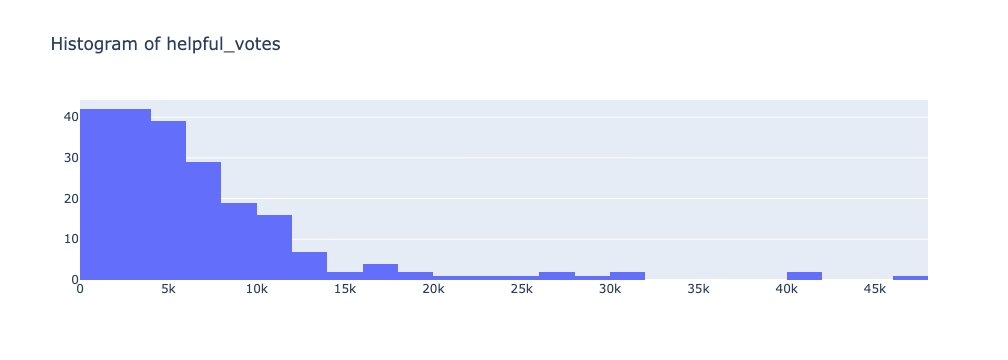

In [21]:
plt = plot_histogram(df, 'helpful_votes', 1000)

* There are clearly noticeable high outliers
* Lets look at a boxplot

###### Save plot
fig = plot_boxplot(df, 'helpful_votes')
fig.update_layout(
        title="Boxplot of Helpful Votes",
        xaxis_title=" ",
        yaxis_title="Number of Helpful Votes",
        title_x=0.5,  # Set title x-alignment to the center
        title_y=0.9   # Set title y-alignment to the top
    )
#pio.write_image(fig, '2_.png')

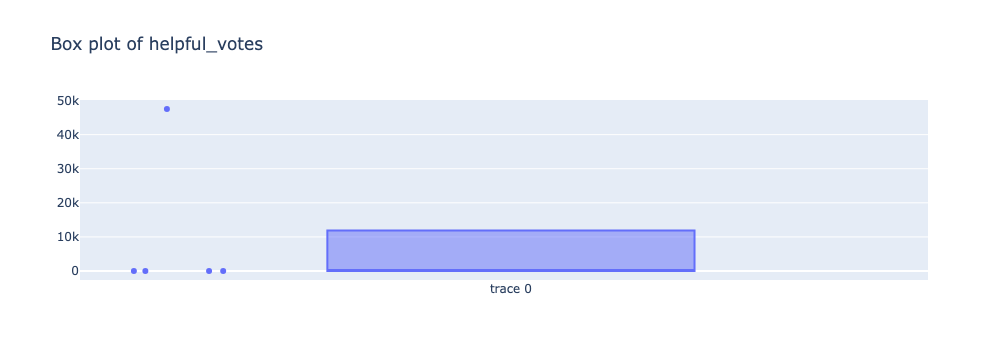

In [22]:
plt = plot_boxplot(df, 'helpful_votes')

* Indeed we see many high outliers
* The boxplot is heavily skewed

plot_boxplot_no_outliers(df, 'helpful_votes')

* Outliers removed box plot, we see most reviews have no votes

###### Save plot
fig = plot_barplot(df, 'star_rating')
fig.update_layout(
        title="Barplot of Star Rating",
        xaxis_title="Star Rating",
        yaxis_title="Counts",
        title_x=0.5,  # Set title x-alignment to the center
        title_y=0.9   # Set title y-alignment to the top
    )
#pio.write_image(fig, '3_.png')

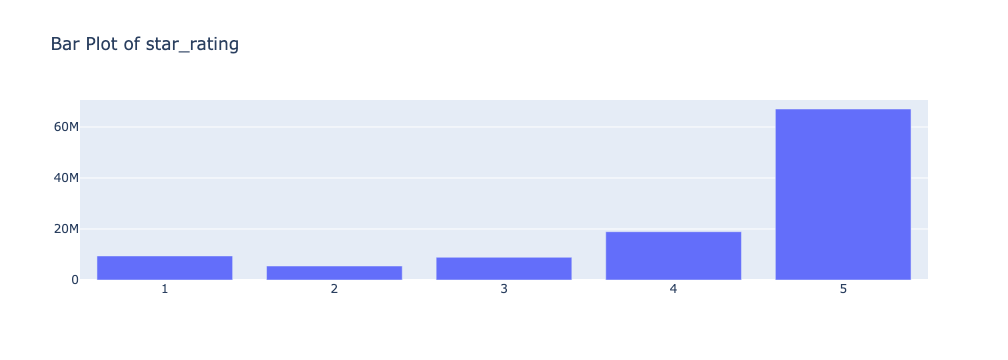

In [23]:
plt = plot_barplot(df, 'star_rating')

* Majority of ratings given are 5 stars
* Second most given rating is 1 but still much less than 5
* Increased ratings from 2 to 5 stars

# Look at category proportions

###### Save plot
fig = plot_barplot(df, 'product_category')
fig.update_layout(
        title="Barplot of Product Category",
        xaxis_title="Product Category",
        yaxis_title="Counts",
        title_x=0.5,  # Set title x-alignment to the center
        title_y=0.9   # Set title y-alignment to the top
    )
#pio.write_image(fig, '4_.png')

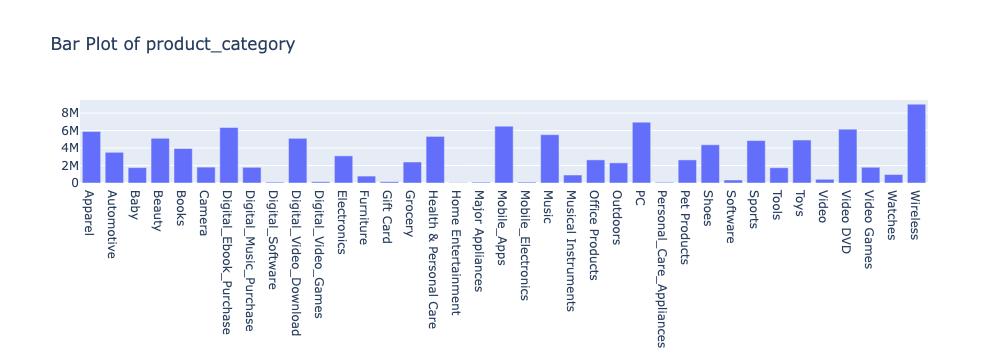

In [24]:
plt = plot_barplot(df, 'product_category')

# Compare purchase counts by year

In [29]:
from pyspark.sql.functions import col, year, substring
import matplotlib.pyplot as plt

def plot_purchase_counts(df, df_name, target_year):
    """
    Plot the purchase counts for a given DataFrame and year.

    Args:
    - df: The DataFrame containing the review data.
    - target_year: The year for which purchase counts will be plotted.
    - df_name: The name of the DataFrame.

    Returns:
    - None
    """
    # Filter the DataFrame to include only rows from the specified year
    df_year = df.filter(F.year(df['review_date']) == target_year)

    # Extract the month from the 'review_date' column
    df_year = df_year.withColumn('review_month', substring(df_year['review_date'], 6, 2))

    # Count the number of purchases for each month
    purchase_counts = df_year.groupby('review_month').count().orderBy('review_month')

    # Plot the counts using a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(purchase_counts.toPandas()['review_month'], purchase_counts.toPandas()['count'])
    plt.title(f'Purchase Counts for {df_name} Year {target_year}')
    plt.xlabel('Month')
    plt.ylabel('Number of Purchases')
    plt.tight_layout()  # Ensures proper layout
    return plt

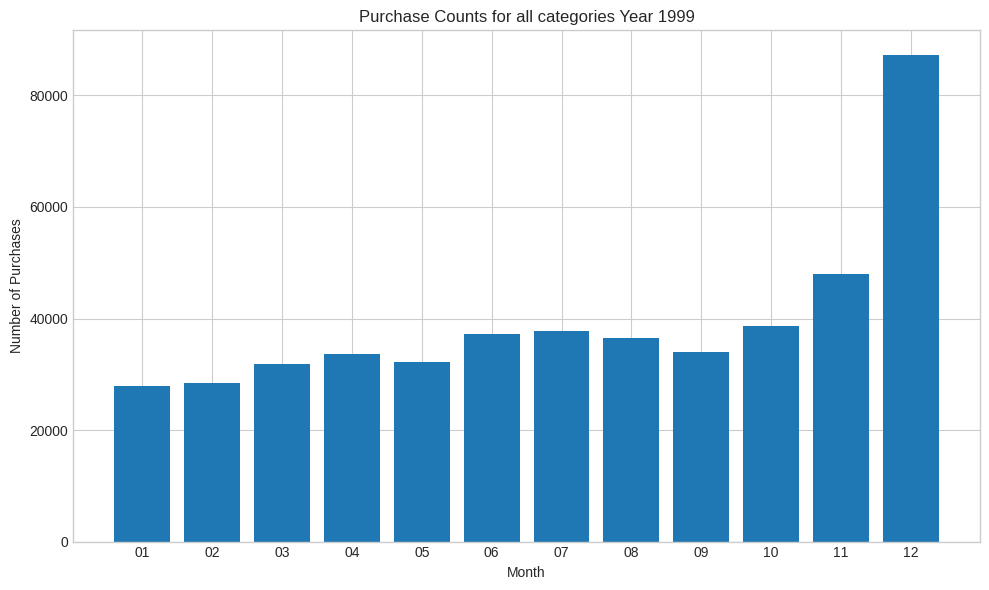

In [30]:
plt = plot_purchase_counts(df, "all categories", 1999)
#plt.savefig('1999.png')

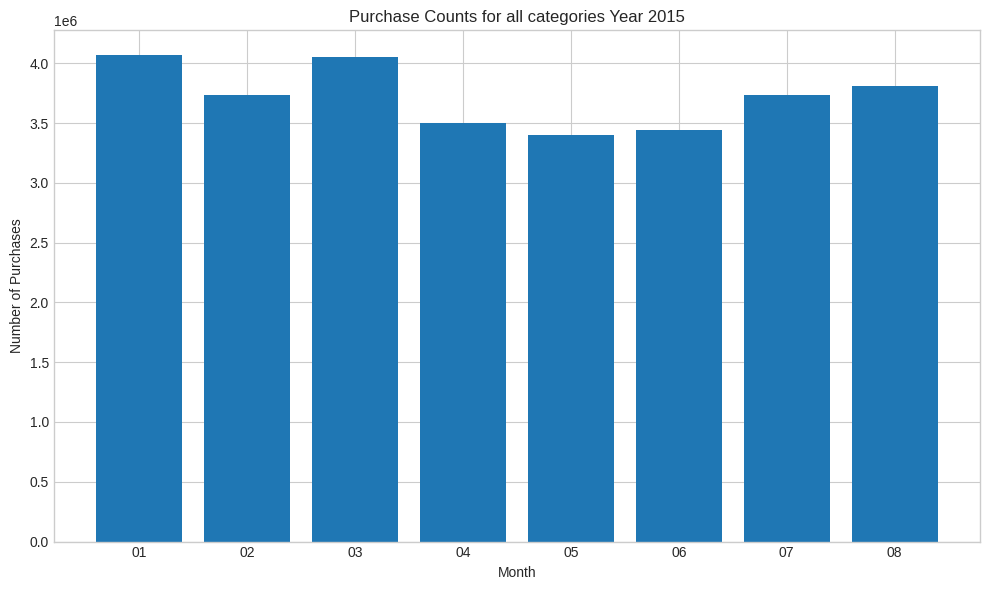

In [31]:
plt = plot_purchase_counts(df, "all categories", 2015)
#plt.savefig('2015.png')

# Look at all years

In [32]:
def plot_yearly_purchase_counts(df, df_name):
    """
    Plot the purchase counts for each year in a given DataFrame.

    Args:
    - df: The DataFrame containing the review data.
    - df_name: The name of the DataFrame.

    Returns:
    - fig: The figure containing the subplots.
    """
    # Extract the year from the 'review_date' column
    df_year = df.withColumn('review_year', F.year(df['review_date']))

    # Count the number of purchases for each year
    purchase_counts = df_year.groupby('review_year').count().orderBy('review_year')

    # Convert to Pandas DataFrame for plotting
    purchase_counts_pd = purchase_counts.toPandas()

    # Plot the counts using a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(purchase_counts_pd['review_year'], purchase_counts_pd['count'])
    plt.title('Historical Yearly Purchase Counts')
    plt.xlabel('Year')
    plt.ylabel('Number of Purchases')
    plt.tight_layout()  # Ensures proper layout
    return plt

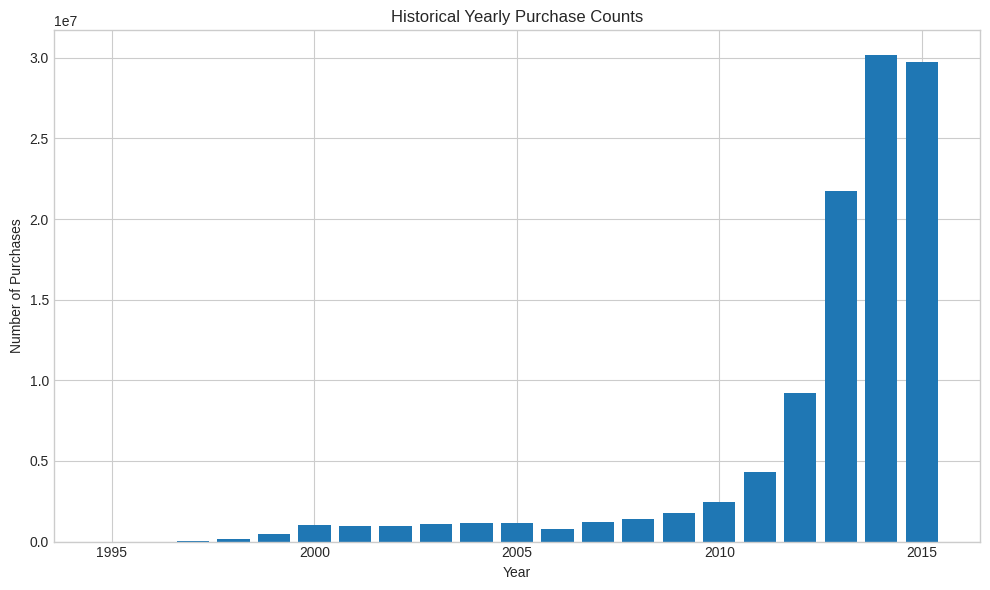

In [33]:
plt = plot_yearly_purchase_counts(df, "all years")
#plt.savefig('counts.png')